<div style="background-color: #d1a8ed; color: black; border: 5px solid #9038b5; padding: 10px;">
  <h1>Clipart Generator</h1>
  <ul>
    <li>Data comes from the 
      <a href="https://www.kaggle.com/datasets/zalando-research/fashionmnist/data" target="_blank" style="color: blue;">Fashion MNIST Dataset</a>.
    </li>
    <li>Here are the 
      <a href="https://github.com/USFCA-MSDS/MSDS-631-GenAI" target="_blank" style="color: blue;">project instructions</a>.
    </li>
    <li>Here is the helper notebook 
      <a href="https://github.com/USFCA-MSDS/MSDS-634/blob/main/VAE.ipynb" target="_blank" style="color: blue;">for VAEs</a>.
    </li>
  </ul>
</div>

---

<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Imports & Functions</h1>
</div>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torch.utils.data import Subset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

import gzip
import os

<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Data Preprocessing</h1>
</div>

# Decompress

In [2]:
mnist_gz_path = 't10k-images-idx3-ubyte.gz'

with gzip.open(mnist_gz_path, 'rb') as f:
    magic_number = int.from_bytes(f.read(4), 'big')
    num_images = int.from_bytes(f.read(4), 'big')
    num_rows = int.from_bytes(f.read(4), 'big')
    num_cols = int.from_bytes(f.read(4), 'big')

    images_data = np.frombuffer(f.read(), dtype=np.uint8)
    images = images_data.reshape(num_images, num_rows, num_cols)

In [3]:
save_dir = 'fashion_mnist_data/digit'
os.makedirs(save_dir, exist_ok=True)

for i in range(num_images):
    img_pil = Image.fromarray(images[i], mode='L').convert("RGB")
    img_pil.save(os.path.join(save_dir, f"fashion_mnist_{i:05d}.png"))  # zero-padded numbering

print(f"Saved {num_images} Fashion MNIST images to {save_dir}")

Saved 10000 Fashion MNIST images to fashion_mnist_data/digit


# View

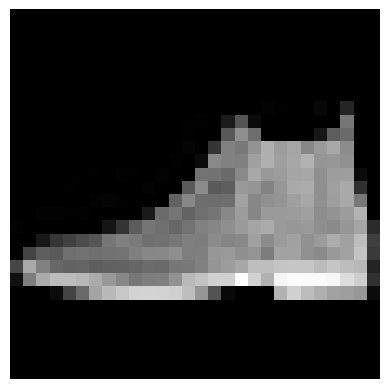

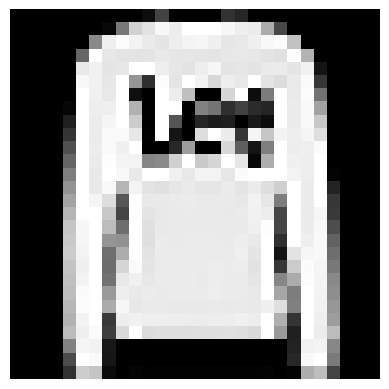

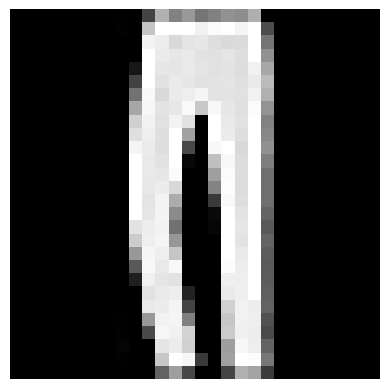

In [4]:
def view_image(image_input):
    """
    Load and display an image from either a file path or a numpy array.
    
    Parameters
    ----------
        - image_input (np.ndarray): Image array to display.
    Returns
    -------
        - None, displays image
    """
    image = Image.fromarray(image_input, mode='L').convert("RGB")
    plt.imshow(image)
    plt.axis('off')
    plt.show()

for i in range(3):
    view_image(images[i])

# Transform

In [5]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root='fashion_mnist_data', transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# # Uncomment if using subset to test code
# indices = list(range(0, 10))  # first 10 images
# subset_dataset = Subset(dataset, indices)
# dataloader = DataLoader(subset_dataset, batch_size=4, shuffle=True)

for images, labels in dataloader:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels: {labels}")
    break

Batch images shape: torch.Size([4, 3, 32, 32])
Batch labels: tensor([0, 0, 0, 0])


<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Model Implementation</h1>
</div>

In [6]:
class ConvVAE(nn.Module):
    """
    A convolutional variational autoencoder (ConvVAE) for generating clipart images from a learned latent space.

    Attributes
    ----------
        - latent_dim (int): Dimensionality of the latent space.
        - encoder (nn.Sequential): Convolutional encoder network.
        - fc_mu (nn.Linear): Linear layer to produce mean of the latent space.
        - fc_logvar (nn.Linear): Linear layer to produce log variance of the latent space.
        - fc_decode (nn.Linear): Linear layer to expand latent vector to decoder input.
        - decoder (nn.Sequential): Convolutional decoder network.
    
    Methods
    -------
        - reparameterize(mu, logvar): Samples latent vector from mean and log variance using reparameterization trick.
        - forward(x): Passes input x through encoder, samples latent space, and reconstructs image.
    """
     
    def __init__(self, latent_dim=16):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 128 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        h_dec = self.fc_decode(z)
        x_recon = self.decoder(h_dec)
        return x_recon, mu, logvar

In [7]:
def train_vae(model_num, latent_dim, lr, num_epochs=500):
    """ 
    Trains a convolutional variational autoencoder (ConvVAE) on the clipart dataset with given hyperparameters.

    Parameters
    ----------
        - model_num (int): Model number used for saving the trained model checkpoint.
        - latent_dim (int): Dimensionality of the latent space.
        - lr (float): Learning rate for the optimizer.
        - num_epochs (int, optional): Number of training epochs (default=10).

    Returns
    -------
        - total_losses (list): List of total loss values for each epoch.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae = ConvVAE(latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(vae.parameters(), lr=lr)
    criterion = nn.BCELoss(reduction='sum')
    recon_losses, kl_losses, total_losses = [], [], []

    print('===========================================================')
    print(f"Model {model_num} (latent={latent_dim}, lr={lr})")
    print('===========================================================\n')
    
    for epoch in tqdm(range(num_epochs)):
        vae.train()
        running_recon_loss, running_kl_loss = 0.0, 0.0
        for images, _ in dataloader:
            images = images.to(device)

            optimizer.zero_grad()
            recon_images, mu, logvar = vae(images)

            recon_loss = criterion(recon_images, images)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + kl_loss

            loss.backward()
            optimizer.step()
            
            running_recon_loss += recon_loss.item()
            running_kl_loss += kl_loss.item()

        recon_losses.append(running_recon_loss / len(dataset))
        kl_losses.append(running_kl_loss / len(dataset))
        total_losses.append((running_recon_loss + running_kl_loss) / len(dataset))

        if epoch % 100 == 0:
            print(f"Epoch {epoch}\n-------")
            print(f"Recon: {recon_losses[-1]:.6f} KL: {kl_losses[-1]:.6f} Total: {total_losses[-1]:.6f}\n")

    # Save model
    os.makedirs("models", exist_ok=True)
    torch.save(vae.state_dict(), f"models/model{model_num}.pt")
    print(f"Saved as models/model{model_num}.pt\n")
    return recon_losses, kl_losses, total_losses

<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Methods</h1>
</div>

In [8]:
latent_dims = [8, 32, 500]
lrs = [1e-3, 5e-4]
all_losses = []

model_num = 1
for latent_dim in latent_dims:
    for lr in lrs:
        recon_losses, kl_losses, total_losses = train_vae(model_num, latent_dim, lr)
        all_losses.append((model_num, latent_dim, lr, recon_losses, kl_losses, total_losses))
        model_num += 1

Model 1 (latent=8, lr=0.001)



  0%|          | 1/500 [00:08<1:09:23,  8.34s/it]

Epoch 0
-------
Recon: 1025.882426 KL: 19.626877 Total: 1045.509303



 20%|██        | 101/500 [12:40<49:57,  7.51s/it] 

Epoch 100
-------
Recon: 911.701377 KL: 20.346276 Total: 932.047654



 40%|████      | 201/500 [25:11<37:28,  7.52s/it]

Epoch 200
-------
Recon: 909.314728 KL: 20.474808 Total: 929.789536



 60%|██████    | 301/500 [37:52<24:57,  7.53s/it]

Epoch 300
-------
Recon: 908.291430 KL: 20.466328 Total: 928.757758



 80%|████████  | 401/500 [50:13<12:08,  7.36s/it]

Epoch 400
-------
Recon: 907.290142 KL: 20.530039 Total: 927.820181



100%|██████████| 500/500 [1:02:28<00:00,  7.50s/it]


Saved as models/model1.pt

Model 2 (latent=8, lr=0.0005)



  0%|          | 1/500 [00:07<1:02:30,  7.52s/it]

Epoch 0
-------
Recon: 1042.586699 KL: 20.801683 Total: 1063.388381



 20%|██        | 101/500 [12:35<49:52,  7.50s/it] 

Epoch 100
-------
Recon: 906.141278 KL: 20.568849 Total: 926.710126



 40%|████      | 201/500 [25:06<37:31,  7.53s/it]

Epoch 200
-------
Recon: 903.063141 KL: 20.686656 Total: 923.749797



 60%|██████    | 301/500 [37:39<25:00,  7.54s/it]

Epoch 300
-------
Recon: 901.617659 KL: 20.822676 Total: 922.440335



 80%|████████  | 401/500 [50:13<12:25,  7.53s/it]

Epoch 400
-------
Recon: 900.825314 KL: 20.852646 Total: 921.677960



100%|██████████| 500/500 [1:02:36<00:00,  7.51s/it]


Saved as models/model2.pt

Model 3 (latent=32, lr=0.001)



  0%|          | 1/500 [00:08<1:07:42,  8.14s/it]

Epoch 0
-------
Recon: 1032.933220 KL: 32.887181 Total: 1065.820401



 20%|██        | 101/500 [13:50<55:01,  8.28s/it] 

Epoch 100
-------
Recon: 891.861594 KL: 30.899529 Total: 922.761123



 40%|████      | 201/500 [27:35<40:58,  8.22s/it]

Epoch 200
-------
Recon: 890.191499 KL: 30.812345 Total: 921.003844



 60%|██████    | 301/500 [41:16<27:07,  8.18s/it]

Epoch 300
-------
Recon: 889.149754 KL: 30.722511 Total: 919.872264



 80%|████████  | 401/500 [54:54<13:34,  8.23s/it]

Epoch 400
-------
Recon: 888.709497 KL: 30.647759 Total: 919.357256



100%|██████████| 500/500 [1:08:31<00:00,  8.22s/it]


Saved as models/model3.pt

Model 4 (latent=32, lr=0.0005)



  0%|          | 1/500 [00:08<1:08:55,  8.29s/it]

Epoch 0
-------
Recon: 1045.341665 KL: 34.402411 Total: 1079.744077



 20%|██        | 101/500 [13:52<54:46,  8.24s/it] 

Epoch 100
-------
Recon: 886.638055 KL: 31.492287 Total: 918.130342



 40%|████      | 201/500 [27:32<41:02,  8.24s/it]

Epoch 200
-------
Recon: 884.637734 KL: 31.162838 Total: 915.800572



 60%|██████    | 301/500 [41:16<27:24,  8.26s/it]

Epoch 300
-------
Recon: 883.672585 KL: 31.058086 Total: 914.730671



 80%|████████  | 401/500 [55:01<13:37,  8.26s/it]

Epoch 400
-------
Recon: 883.245330 KL: 31.008311 Total: 914.253641



100%|██████████| 500/500 [1:08:33<00:00,  8.23s/it]


Saved as models/model4.pt

Model 5 (latent=500, lr=0.001)



  0%|          | 1/500 [00:22<3:06:54, 22.47s/it]

Epoch 0
-------
Recon: 1067.359366 KL: 45.558292 Total: 1112.917659



 20%|██        | 101/500 [40:04<2:39:46, 24.03s/it]

Epoch 100
-------
Recon: 902.541343 KL: 31.337497 Total: 933.878840



 40%|████      | 201/500 [1:19:58<1:59:46, 24.04s/it]

Epoch 200
-------
Recon: 899.634003 KL: 30.715146 Total: 930.349149



 60%|██████    | 301/500 [1:59:37<1:19:58, 24.11s/it]

Epoch 300
-------
Recon: 898.528816 KL: 30.491548 Total: 929.020365



 80%|████████  | 401/500 [2:39:14<38:20, 23.23s/it]  

Epoch 400
-------
Recon: 898.183706 KL: 30.405159 Total: 928.588865



100%|██████████| 500/500 [3:18:01<00:00, 23.76s/it]


Saved as models/model5.pt

Model 6 (latent=500, lr=0.0005)



  0%|          | 1/500 [00:23<3:14:03, 23.33s/it]

Epoch 0
-------
Recon: 1070.921317 KL: 45.686160 Total: 1116.607477



 20%|██        | 101/500 [40:41<2:42:01, 24.36s/it]

Epoch 100
-------
Recon: 894.507434 KL: 31.373175 Total: 925.880610



 40%|████      | 201/500 [1:20:53<2:00:32, 24.19s/it]

Epoch 200
-------
Recon: 891.425369 KL: 30.696362 Total: 922.121731



 60%|██████    | 301/500 [1:59:38<1:17:06, 23.25s/it]

Epoch 300
-------
Recon: 890.064532 KL: 30.446186 Total: 920.510718



 80%|████████  | 401/500 [2:38:04<39:51, 24.16s/it]  

Epoch 400
-------
Recon: 889.095418 KL: 30.257534 Total: 919.352952



100%|██████████| 500/500 [3:15:05<00:00, 23.41s/it]

Saved as models/model6.pt



<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Experiments & Results</h1>
</div>

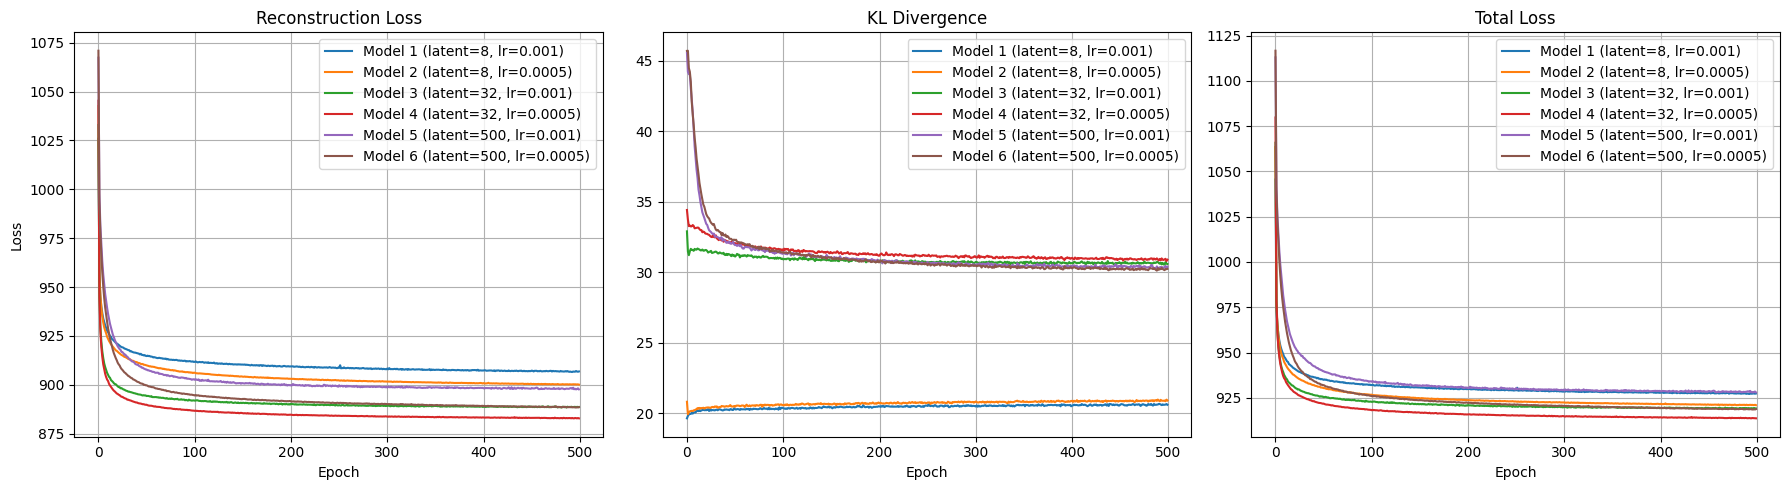

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

for model_num, latent_dim, lr, recon_losses, kl_losses, total_losses in all_losses:
    axs[0].plot(recon_losses, label=f"Model {model_num} (latent={latent_dim}, lr={lr})")
    axs[1].plot(kl_losses, label=f"Model {model_num} (latent={latent_dim}, lr={lr})")
    axs[2].plot(total_losses, label=f"Model {model_num} (latent={latent_dim}, lr={lr})")

axs[0].set_title('Reconstruction Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

axs[1].set_title('KL Divergence')
axs[1].set_xlabel('Epoch')
axs[1].legend()
axs[1].grid(True)

axs[2].set_title('Total Loss')
axs[2].set_xlabel('Epoch')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [10]:
def load_model_and_generate(model_num):
    """ 
    Loads a trained VAE model and generates a grid of new clipart images.

    Parameters
    ----------
        - model_num (int): The model number corresponding to a saved model in the 'models/' directory.

    Returns
    -------
        - None: Displays a grid of generated images using matplotlib.
    """
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model2latent = {
        1: 8,    # Model 1: latent_dim=8
        2: 8,    # Model 2: latent_dim=8
        3: 32,   # Model 3: latent_dim=32
        4: 32,   # Model 4: latent_dim=32
        5: 500,  # Model 5: latent_dim=500
        6: 500   # Model 6: latent_dim=500
    }
    
    latent_dim = model2latent[model_num]
    vae = ConvVAE(latent_dim=latent_dim).to(device)
    vae.load_state_dict(torch.load(f"models/model{model_num}.pt"))
    vae.eval()

    with torch.no_grad():
        z = torch.randn(64, latent_dim).to(device)
        h_dec = vae.fc_decode(z)
        samples = vae.decoder(h_dec).cpu()
        grid = make_grid(samples, nrow=8, normalize=True)
        plt.figure(figsize=(10, 10))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis('off')
        plt.title(f'Generated Samples (Model {model_num})')
        plt.show()

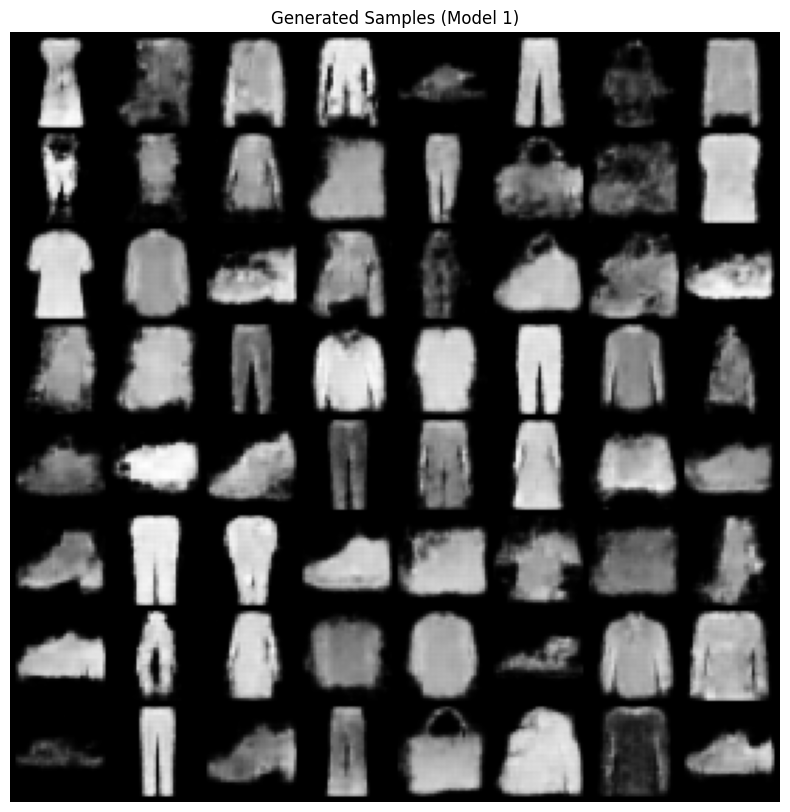

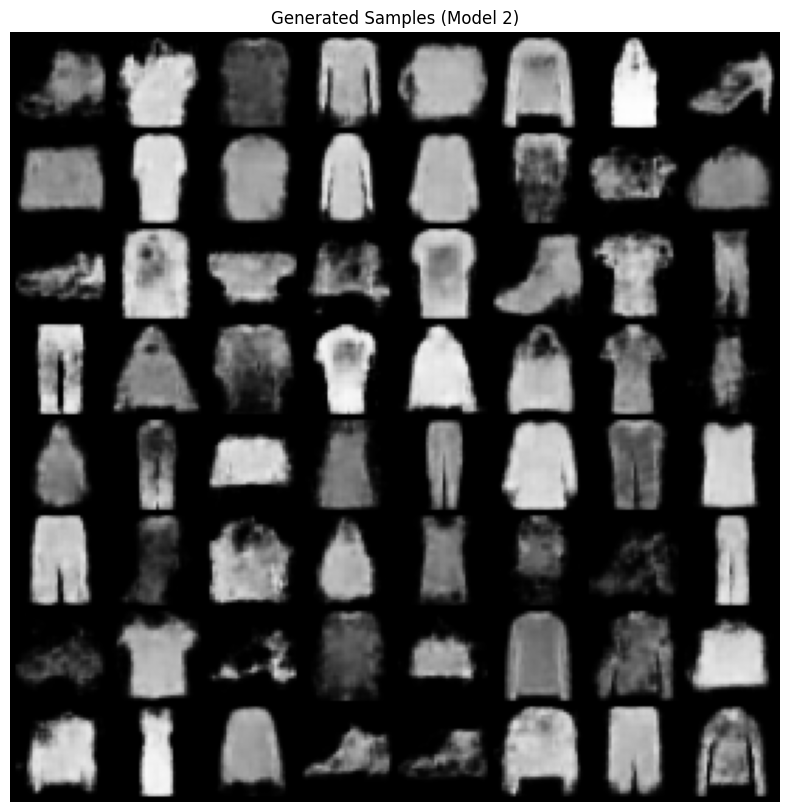

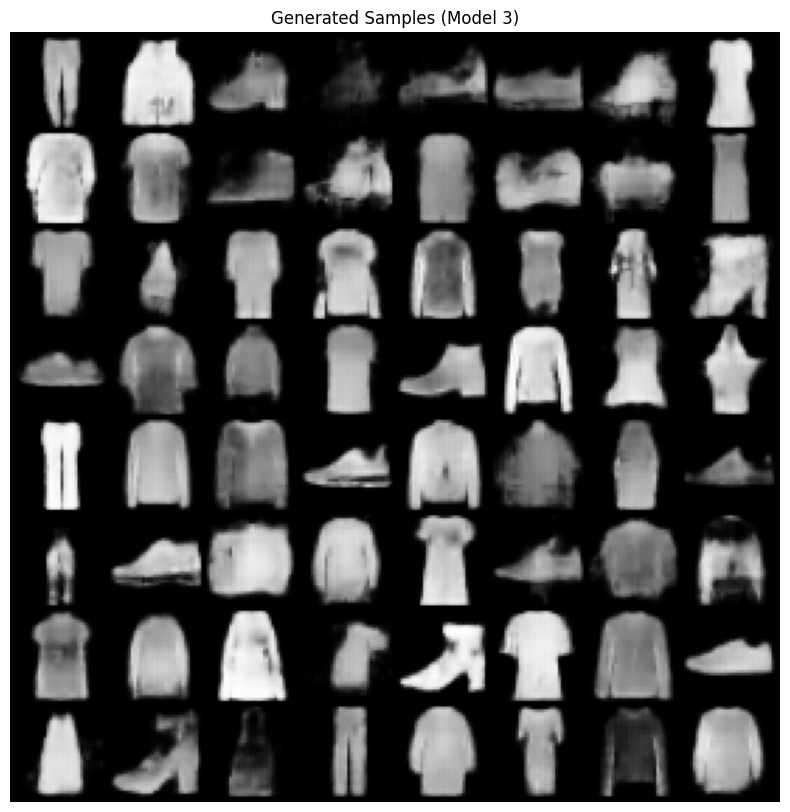

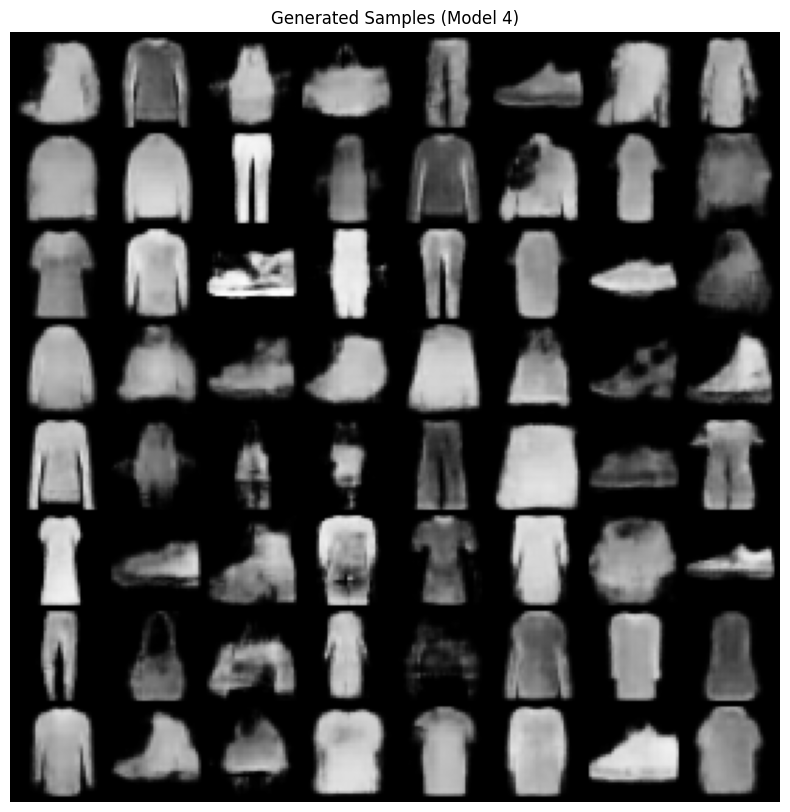

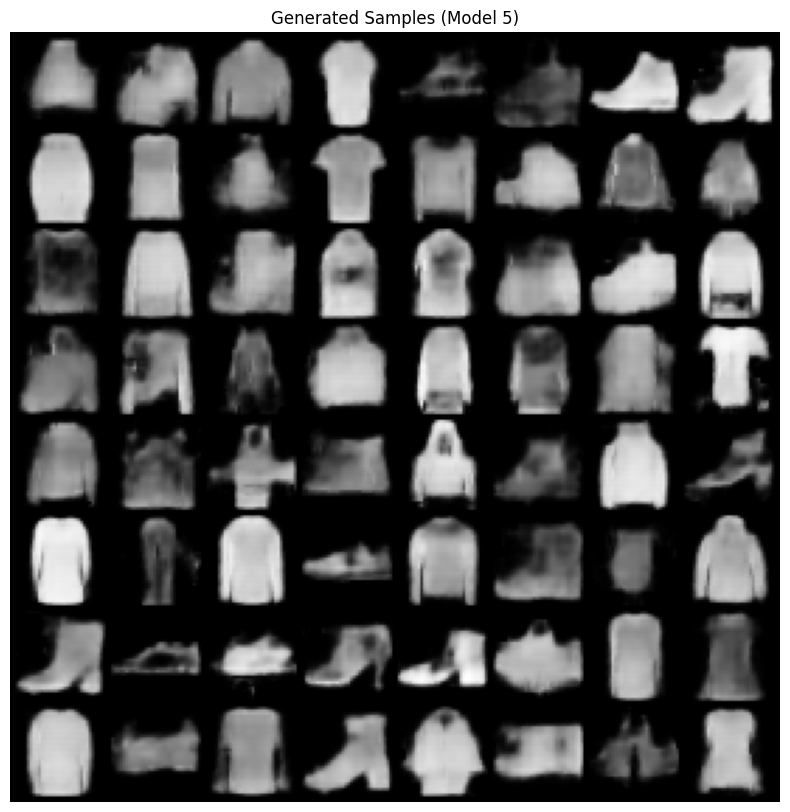

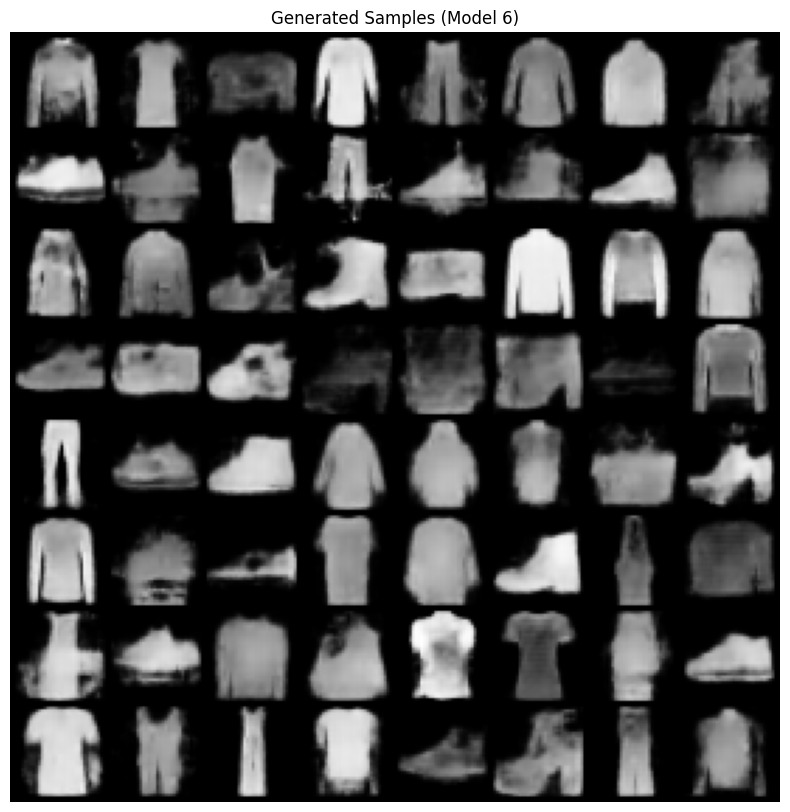

In [11]:
for i in range(1, 7):
    load_model_and_generate(i)